# AI Computer Assignment 3 ( Naive Bayes Classifier)
Mohammad Saadati - 
_810198410_

## Introduction
In this project, we intend to use Naive Bayes Classifier to analyze "Divar" site ads and categorize them, and try to predict the category using the data we have about the title and description of each ad. .

In [43]:
from __future__ import unicode_literals
import pandas as pd
import numpy as np
from hazm import *
import math
import matplotlib.pyplot as plt
import operator

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df

,content,label
0,فیلم‌های در حال اکران؛ موزیکال شاد خاله قورباغ...,هنر و سینما
1,پنج فیلمسازی که کوئنتین تارانتینو را عاشق سینم...,هنر و سینما
2,جانی آیو از اپل رفت جانی آیو دیگر نیازی به معر...,علم و تکنولوژی
3,احتمال عدم پشتیبانی iOS ۱۳ از آیفون ۵ اس، SE و...,علم و تکنولوژی
4,دزدان مغازه نماینده ژاپن در اسکار ۲۰۱۹ شد فیلم...,هنر و سینما
...,...,...
5195,امپراطوری اپ (فصل اول/بخش دوم) فصل اول – بخش د...,سلامت و زیبایی
5196,عدم ارتباطات اثربخش و تعارض در محیط کار وجود س...,سلامت و زیبایی
5197,اپل در سال ۲۰۲۰ چهار آیفون معرفی خواهد کرد! طب...,علم و تکنولوژی
5198,مارتینز: بلژیک باید مقابل فرانسه بدون ترس بازی...,سلامت و زیبایی


In [44]:
test_df

,content,label
0,با این ۵ صبحانه رژیمی لاغر شوید صبحانه همیشه ب...,سلامت و زیبایی
1,نمایشگر گوشی تاشونده ال‌جی مانند بروشور باز و ...,علم و تکنولوژی
2,چرا برخی سلبریتی‌های هالیوودی از شبکه‌های اجتم...,هنر و سینما
3,گوگل استیدیا؛ آینده‌ی صنعت بازی یا محکوم به شک...,بازی ویدیویی
4,ویژگی جذاب گلکسی Z Flip به زودی به گوشی‌های ان...,علم و تکنولوژی
...,...,...
797,برادران داردن با فیلمی درباره افراطی‎گری به کن...,هنر و سینما
798,Death Stranding پر از میان‌پرده‌های طولانی است...,بازی ویدیویی
799,حالت نیو گیم پلاس به اسپایدرمن اضافه می‌شود چن...,بازی ویدیویی
800,چگونه مثل جف بزوس هک نشویم؛ ۵ توصیه امنیتی برا...,علم و تکنولوژی


## Phase 1: Data preprocessing
Merging title and description and removing the title and description columns so our processes will be done on the new merged column named  'all'. All preprocesses are done below. We finding the numbers of each word in each class that will be needed for calculationg probability.

In [45]:
lemmatizer = Lemmatizer()
normalizer = Normalizer()

def remove_stopword_and_lemmatize(words):
    stop_words = set(stopwords_list())
    result = set()
    for word in words:
        if(word not in stop_words):
            result.add(lemmatizer.lemmatize(word))
    return result

def remove_punctuation_and_whitespace(text):
    counter = 0
    punctuation = set('''?\#$%@&^.؟؛][=*×،!-+ـ)(٪:«»<>…/_.,{};~'"|٬٫''')
    whitespace = {"\n" , "\r" , "\t", "\u200c"}
    while(counter < len(text)):
        if(text[counter] in whitespace or text[counter] in punctuation):
            text = text[:counter] + "" + text[counter+1:]
            continue
        counter += 1
    return word_tokenize(text)
 
def cal_train_info(trainInfo , words , category):
    for word in words:
        all_categories_words.add(word)
        train_counts[category] += 1
        if(word in train_info[category].keys()):
            train_info[category][word] += 1
        else:
            train_info[category][word] = 1

train_df["content"] = train_df["content"].fillna("")
train_df["label"] = train_df["label"].fillna("")
test_df["content"] = test_df["content"].fillna("")
test_df["label"] = test_df["label"].fillna("")

train_df["content"] = train_df["content"].apply(normalizer.normalize)
train_df["content"] = train_df["content"].apply(remove_punctuation_and_whitespace)
train_df["content"] = train_df["content"].apply(remove_stopword_and_lemmatize)
train_df["label"] = train_df["label"].apply(normalizer.normalize)

test_df["content"] = test_df["content"].apply(normalizer.normalize)
test_df["content"] = test_df["content"].apply(remove_punctuation_and_whitespace)
test_df["content"] = test_df["content"].apply(remove_stopword_and_lemmatize)
test_df["label"] = test_df["label"].apply(normalizer.normalize)

train_counts = {"سلامت و زیبایی": 0 , "علم و تکنولوژی": 0 , "هنر و سینما": 0 , "بازی ویدیویی": 0}
train_info = {"سلامت و زیبایی": {} , "علم و تکنولوژی": {} , "هنر و سینما": {} , "بازی ویدیویی": {}}
all_categories_words = set()
train_df.apply(lambda row : cal_train_info(train_info , row["content"] , row["label"]), axis = 1);

### Question 1:
Stemming tries to remove postfix of words to generate the main parts them but sometimes there can be some mistakes or shall we say undesired outputs. Stemming won't do the same thing as lemmatization with verbs but for noun it's partially the same.

Lemmatization is a way of getting the root of words. This procedure is very useful with verbs. Also this procedure can be useful with noun. For nouns what we need is the main part of it meaning that we don't want the plural words or any other part of speech connected to it. Lemmatization will remove all these unnecessary parts and gives us the main part of each part of speech.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma. Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time not all the time, and often includes the removal of derivational affixes.

## Phase 2: The Problem Process
Calculating probabilities and finding the maximum probability. This part is used for finding accuracy.

In [47]:
def cal_bayes_with_smoothing(train_info , train_vounts , test_words):
    alpha = 0.2
    cur_ategory = ""
    p_max = float("-inf"); 
    for cur_category , categoryWords in train_info.items():
        cur_p = math.log(1/4)  
        for test_word in test_words:
            if(test_word not in categoryWords.keys()):
                cur_p += math.log(alpha / (train_counts[cur_category] + alpha * len(all_categories_words) ) )
            else:
                cur_p += math.log((categoryWords[test_word] + alpha) / (train_counts[cur_category] + alpha * len(all_categories_words)))
        if(p_max < cur_p ):
            cur_ategory = cur_category
            p_max = cur_p  
    return cur_ategory


test_df["bayes_result_with_additive_smoothing"] = test_df.apply(lambda row : cal_bayes_with_smoothing(train_info , train_counts , row["content"]) , axis = 1);
test_df["validity_with_additive_smoothing"] = np.where(test_df["label"] == test_df["bayes_result_with_additive_smoothing"], True, False)
test_df["validity_with_additive_smoothing"].value_counts()

True     766
False     36
Name: validity_with_additive_smoothing, dtype: int64

In [48]:
def cal_bayes(train_info , train_counts , test_words):
    cur_ategory = "personal"
    p_max = float("-inf")
    for cur_category , categoryWords in train_info.items():      
        cur_p = math.log(1/4) 
        for test_word in test_words:
            if(test_word not in categoryWords.keys()):
                cur_p += float("-inf") 
            else:
                cur_p += math.log(categoryWords[test_word] / train_counts[cur_category])
        if(p_max < cur_p):
            cur_ategory = cur_category
            p_max = cur_p       
    return cur_ategory

test_df["bayes_result_without_additive_smoothing"] = test_df.apply(lambda row : cal_bayes(train_info , train_counts , row["content"]), axis = 1);
test_df["validity_without_additive_smoothing"] = np.where(test_df["label"] == test_df["bayes_result_without_additive_smoothing"], True, False)
test_df["validity_without_additive_smoothing"].value_counts()

False    713
True      89
Name: validity_without_additive_smoothing, dtype: int64

### Question 2:
Posterior: Probability of a word belonging to the mentioned categories given the word. We can decide the category of a text or in other words a new set of words by comparing this probability for our 6 categories.

Prior: Probabilty of the category occurrence in general. This value can be calculated or simply be 1/6 meaning that we'll assign equal probability to occurrence of each category.

Likelihood: It's the probability of a word occurring given the category. So it's the number of that word occurring in one of the categories divided by the number of all the words in the same category.

Evidence: Probability of the word itself which is the number of that word occurring in the dataset. Because this number is independent of the class and we are going to compare probability of the classes given the same words this number would be the same in both sides of the comparison so we can ignore it and never calculate it meaning that here we can calculate and compare everything without this value.

### Question 3:
The best we can do is to fight back and bring in sky high success. The sky is beautiful today.

Since the report is in English, English examples are provided

Here the word sky can show the need for bigrams or n-grams clearly. By using unigrams, in both of the examples the sky will mean as the blue sky above us. Although this meaning is correct for the second sentence, there's a different situation in the first sentence. In the fisrt one, sky is an adverb for the word high and simply means very. So the only way we can correctly guess the meaning of the word is by using n-grams and showing that the there words sky, high and success are dependent. In the mentioned example bigrams aren't adequate since it'll only give us sky high, we know that this is and adjective but we still don't know to what word so using 3-grams will do the trick.

### Question 4:
In case that there is word contained only one type of category, Naive Bayes will definetly choose that category as the answer which might be wrong in some cases. If a word doesn't exist in the dataset of a category,  we have that $P(x|c) = 0$
The reason is that $log(0) = - \infty$ so the sum $ sum_{i=1}^{n} log(P(x_i | c)) $ will converge to $- \infty$ so the probability of that category will be zero and since we are multiplying p by this words probability which is 0 or in another way getting log of a zero which will return -inf therefore that test data will definitely be classified in one of the other categories because of that one and only word. Since here we're using log for calculation the result will be -inf and according to the code that category certainly won't be selected. When word $x$ hasn't appeared in genre $c$, and never will be chosen as the genre since wre choosing the genre which maximizes the sum mentioned above.

### Question 5:
Additive smoothing is a technique for smoothing categorical data. In additive smoothing we are trying to prevent zero probability. A small-sample correction will be incorporated in every probability estimate. Consequently, no probability will be zero and this really comes in handy since there can be new words in the test dataset that we haven't seen in the train dataset, this is a way of regularizing Naive Bayes.

This'll be achieved by changing the way we calculate probability of each word given the class. By adding alpha which is greater zero it's guaranteed that the probability for each word won't be zero:

$$ p(word|class) = \frac{word + \alpha}{N + \alpha.D} $$

* alpha is coefficient that is greater than zero and usually less than 1.
* N is all words in that particular class.
* D is number of possible words in all 6 categories (without the duplicates meaning that all the words are unique)

### Verification

### Question 6:

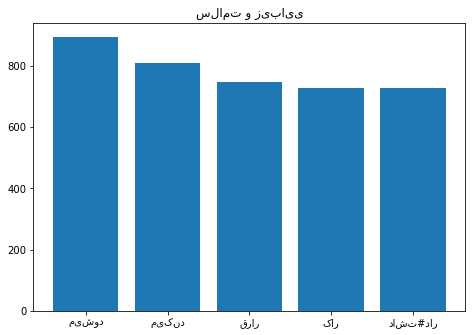

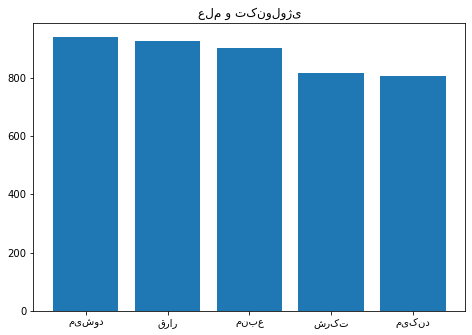

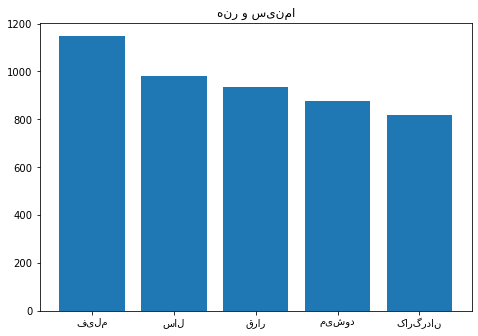

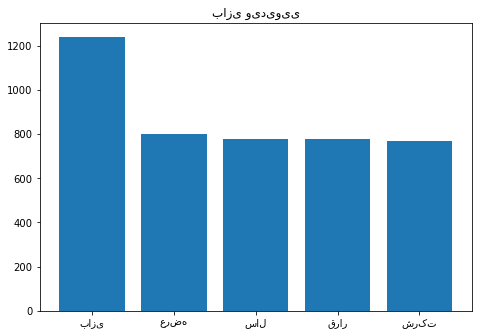

In [49]:
for cur_category in train_info.keys():
    fig = plt.figure()
    train_info_with_sort = dict(sorted(train_info[cur_category].items(), key=operator.itemgetter(1), reverse=True)[:5])
    words = [word for word in train_info_with_sort.keys()]
    numbers = [num for num in train_info_with_sort.values()]
    ax = fig.add_axes([0,0,1,1])
    ax.bar(words , numbers)
    ax.set_title(cur_category)
    plt.show()

## Phase 3: Evaluation

### Question 7:
Precision can be seen as a measure of exactness or quality but recall is a measure of completeness or quantity meaning high precision shows that an algorithm returned substantially more relevant results than irrelevant ones but high recall means that an algorithm returned most of the relevant results.

For example lets assume that we are creating a model to classify banking transactions into Fraud and Not Fraud classes.
ussually there is a little percent of fraud transactions in the whole transactions data.

Recall = frauds correctly identified / (frauds correctly identified + frauds incorrectly labeled as not frauds)

Lets assume that our model lablels every transaction as fraud so according to the earlier equation we have a recall of 100%
But obiously this is not a good model because we are false labeling lots of none fraud transactions and interrupt them. And according to the Precision formula:

Precision = frauds correctly identified / (frauds correctly identified + transactions incorrectly labeled as fraud)

We see that we are getting a really low precision but a high recall and its not a good model.

### Question 8:
The F1 score is the harmonic mean of the precision and recall.The highest possible value of an F-score is 1, indicating perfect precision and recall, and the lowest possible value is 0, if either the precision or the recall is zero. We use this mean method so a model with recall 100% and precision 0% gets a low score. And punishes the extreme value that was high at the cost of the other value.
If we used the normal mean equation we will end up on a value that is higher and its not a good metric because we don't want both of precision and recall to be more than a certain threshold. 
The F1 score kinda combines recall and precision and it's a better score to meausure our model predictions.

### Question 9:
* Macro: computess F1 for each label, and returns the average without considering the proportion for each label in the dataset.
* Micro: computes F1 by value total true positives, false negatives and false positives (no matter of the prediction for each label in the dataset)
* Weighted: computes F1 for each label, and returns the average considering the proportion for each label in the dataset.

### Question 10:

for each class:
* Precision  = number of correct predictions / all predictions of that class

* recall = number of correct predictions / all actual data of that class

accuracy = number of correct predictions in total / all data

#### Part A: With additive smoothing

* سلامت و زیبایی *
Precision: 95.06172839506173%  
Recall: 95.65217391304348%  
F1: 95.3560371517028% 

* بازی ویدیویی *
Precision: 96.35416666666666%  
Recall: 93.90862944162437%  
F1: 95.11568123393317% 

* علم و تکنولوژی *
Precision: 96.0431654676259%  
Recall: 96.38989169675091%  
F1: 96.21621621621621% 

* هنر و سینما *
Precision: 94.11764705882352%  
Recall: 95.80838323353294%  
F1: 94.95548961424332% 

Accuracy: 95.51122194513717%
True     766
False     36
Name: validity_with_additive_smoothing, dtype: int64


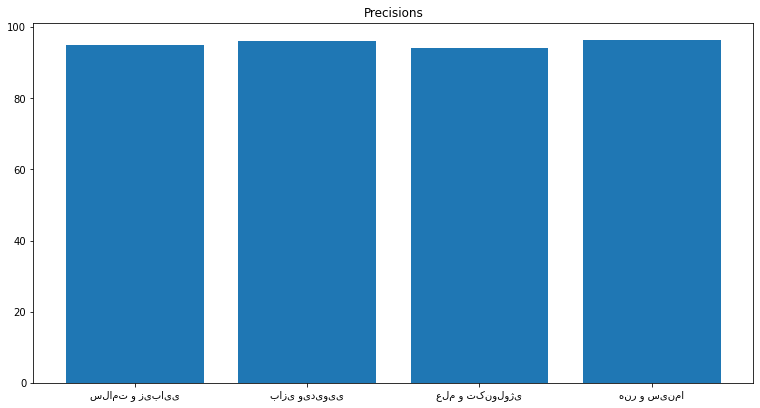

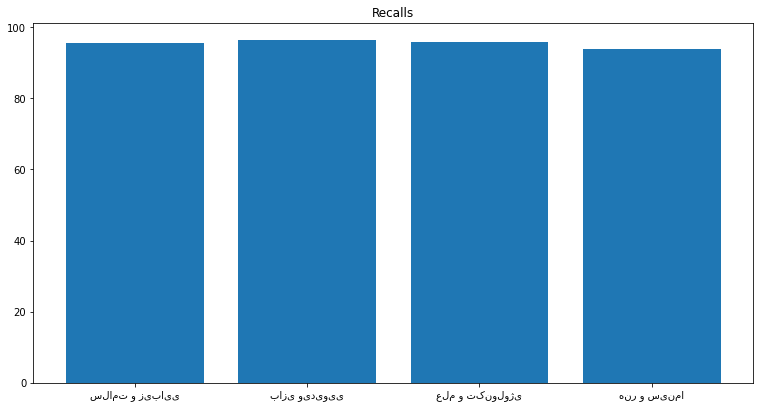

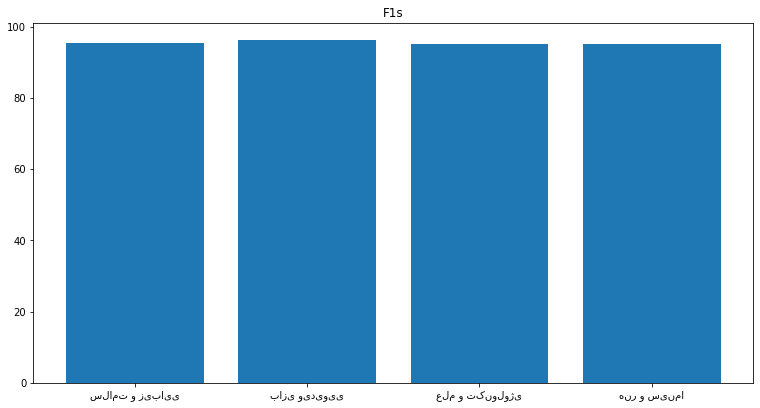

In [50]:
precisions =  {"سلامت و زیبایی": 0 , "علم و تکنولوژی": 0 , "هنر و سینما": 0 , "بازی ویدیویی": 0}
recalls =  {"سلامت و زیبایی": 0 , "علم و تکنولوژی": 0 , "هنر و سینما": 0 , "بازی ویدیویی": 0}
F1s =  {"سلامت و زیبایی": 0 , "علم و تکنولوژی": 0 , "هنر و سینما": 0 , "بازی ویدیویی": 0}
numAcutalData =  {"سلامت و زیبایی": 0 , "علم و تکنولوژی": 0 , "هنر و سینما": 0 , "بازی ویدیویی": 0}
categoriesNames = set(test_df["label"])

for cur_category in categoriesNames:
    num_acutal_data = 0
    num_preds = 0
    correct_preds = 0
    for i in range(len(test_df)):
        if(test_df.loc[i , "bayes_result_with_additive_smoothing"] == cur_category):
            num_preds += 1
        if(test_df.loc[i , "label"] == cur_category):
            num_acutal_data += 1
            if(test_df.loc[i , "label"] == test_df.loc[i , "bayes_result_with_additive_smoothing"]):
                correct_preds += 1
    precisions[cur_category] = (correct_preds / num_preds) * 100
    numAcutalData[cur_category] = num_acutal_data
    recalls[cur_category] = (correct_preds / num_acutal_data) * 100
    F1s[cur_category] = 2 * (precisions[cur_category] * recalls[cur_category]) / (precisions[cur_category] + recalls[cur_category])
    
for cur_category in categoriesNames:
    print("* " + cur_category + " *")
    print("Precision: " + str(precisions[cur_category]) + "%  \nRecall: " + str(recalls[cur_category]) + \
          "%  \nF1: " + str(F1s[cur_category]) + "% \n")

print("Accuracy: " + str((test_df["validity_with_additive_smoothing"].value_counts()[1] / len(test_df)) * 100) + "%")
print(test_df["validity_with_additive_smoothing"].value_counts())

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Precisions")
categories = list(categoriesNames)
numbers = list(precisions.values())
ax.bar(categories , numbers)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Recalls")
categories = list(categoriesNames)
numbers = list(recalls.values())
ax.bar(categories , numbers)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("F1s")
categories = list(categoriesNames)
numbers = list(F1s.values())
ax.bar(categories , numbers)
plt.show()

macro average : normal average

weighted average : each percentage is multiplied by the number of acutal data of that class

micro average : In our case all precision, recall and F1 will be equal to accuracy

Macro Average Precision: 95.39417689704445%
Macro Average Recall: 95.43976957123793%
Macro Average F1: 95.41085605402388%


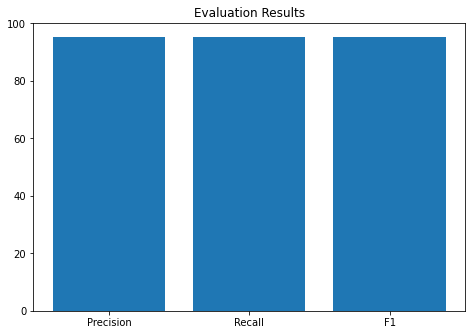

In [51]:
macroAvgPrecision = sum(precisions.values()) / len(categoriesNames)
macroAvgRecall = sum(recalls.values()) / len(categoriesNames)
macroAvgF1 = sum(F1s.values()) / len(categoriesNames)
print("Macro Average Precision: " + str(macroAvgPrecision) + "%")
print("Macro Average Recall: " + str(macroAvgRecall) + "%")
print("Macro Average F1: " + str(macroAvgF1) + "%")
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Evaluation Results")
words = ["Precision" , "Recall" , "F1"]
numbers = [macroAvgPrecision , macroAvgRecall , macroAvgF1]
ax.bar(words , numbers)
plt.show()

Weighted Average Precision: 95.52158727966855%
Weighted Average Recall: 95.51122194513715%
Weighted Average F1: 95.51068558850312%


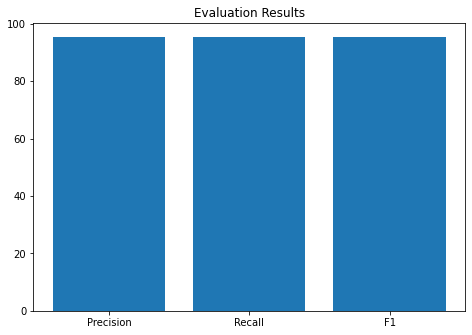

In [52]:
weightedAvgPrecision = 0; weightedAvgRecall = 0; weightedAvgF1 = 0
for category in categoriesNames:
    weightedAvgPrecision += (numAcutalData[category] * precisions[category])
    weightedAvgRecall += (numAcutalData[category] * recalls[category])
    weightedAvgF1 += (numAcutalData[category] * F1s[category]) 
weightedAvgPrecision /= len(test_df)
weightedAvgRecall /= len(test_df)
weightedAvgF1 /= len(test_df)
print("Weighted Average Precision: " + str(weightedAvgPrecision) + "%")
print("Weighted Average Recall: " + str(weightedAvgRecall) + "%")
print("Weighted Average F1: " + str(weightedAvgF1) + "%")
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Evaluation Results")
words = ["Precision" , "Recall" , "F1"]
numbers = [weightedAvgPrecision , weightedAvgRecall , weightedAvgF1]
ax.bar(words , numbers)
plt.show()

In [53]:
accuracy = str((test_df["validity_with_additive_smoothing"].value_counts()[1] / len(test_df)) * 100)
print("Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = " + accuracy + "%")

Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = 95.51122194513717%


#### Part B: without additive smoothing

* سلامت و زیبایی *
Precision: 92.3076923076923%  
Recall: 7.453416149068323%  
F1: 13.793103448275861% 

* بازی ویدیویی *
Precision: 100.0%  
Recall: 17.766497461928935%  
F1: 30.17241379310345% 

* علم و تکنولوژی *
Precision: 96.42857142857143%  
Recall: 9.747292418772563%  
F1: 17.704918032786885% 

* هنر و سینما *
Precision: 88.23529411764706%  
Recall: 8.982035928143713%  
F1: 16.304347826086957% 

Accuracy: 11.097256857855362%
False    713
True      89
Name: validity_without_additive_smoothing, dtype: int64


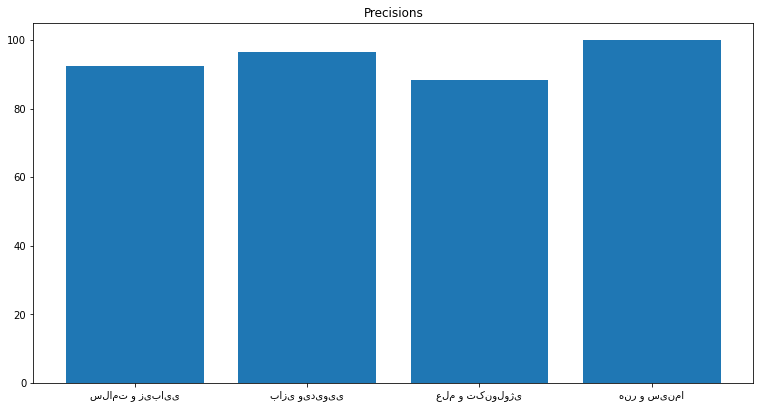

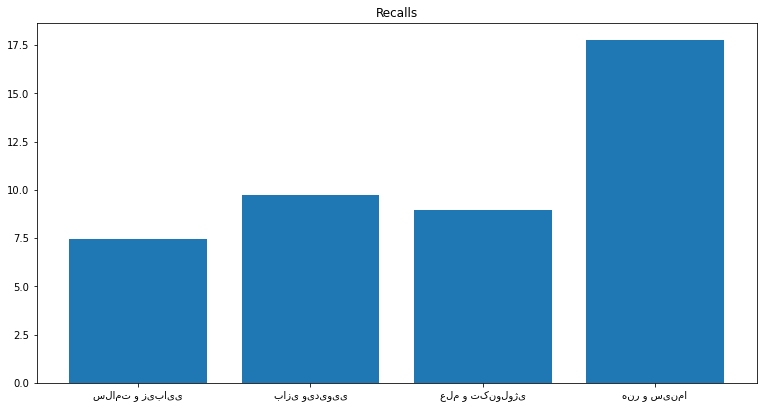

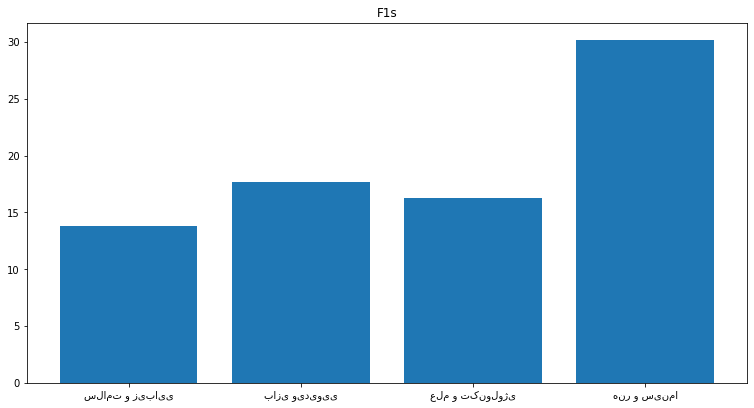

In [54]:
for cur_category in categoriesNames:
    num_acutal_data = 0
    num_preds = 0
    correct_preds = 0
    for i in range(len(test_df)):
        if(test_df.loc[i , "bayes_result_without_additive_smoothing"] == cur_category):
            num_preds += 1
        if(test_df.loc[i , "label"] == cur_category):
            num_acutal_data += 1
            if(test_df.loc[i , "label"] == test_df.loc[i , "bayes_result_without_additive_smoothing"]):
                correct_preds += 1    
    precisions[cur_category] = (correct_preds / num_preds) * 100
    numAcutalData[cur_category] = num_acutal_data
    recalls[cur_category] = (correct_preds / num_acutal_data) * 100
    F1s[cur_category] = 2 * (precisions[cur_category] * recalls[cur_category]) / (precisions[cur_category] + recalls[cur_category])

for cur_category in categoriesNames:
    print("* " + cur_category + " *")
    print("Precision: " + str(precisions[cur_category]) + "%  \nRecall: " + str(recalls[cur_category]) + \
          "%  \nF1: " + str(F1s[cur_category]) + "% \n")

print("Accuracy: " + str((test_df["validity_without_additive_smoothing"].value_counts()[1] / len(test_df)) * 100) + "%")
print(test_df["validity_without_additive_smoothing"].value_counts())

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Precisions")
words = list(categoriesNames)
numbers = list(precisions.values())
ax.bar(words , numbers)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Recalls")
words = list(categoriesNames)
numbers = list(recalls.values())
ax.bar(words , numbers)
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("F1s")
words = list(categoriesNames)
numbers = list(F1s.values())
ax.bar(words , numbers)
plt.show()


Macro Average Precision: 94.2428894634777%
Macro Average Recall: 10.987310489478382%
Macro Average F1: 19.493695775063287%


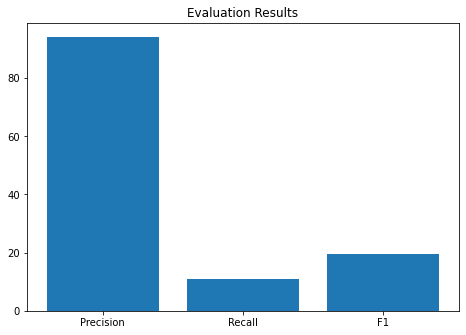

In [55]:
macroAvgPrecision = sum(precisions.values()) / len(categoriesNames)
macroAvgRecall = sum(recalls.values()) / len(categoriesNames)
macroAvgF1 = sum(F1s.values()) / len(categoriesNames)
print("Macro Average Precision: " + str(macroAvgPrecision) + "%")
print("Macro Average Recall: " + str(macroAvgRecall) + "%")
print("Macro Average F1: " + str(macroAvgF1) + "%")
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Evaluation Results")
words = ["Precision" , "Recall" , "F1"]
numbers = [macroAvgPrecision , macroAvgRecall , macroAvgF1]
ax.bar(words , numbers)
plt.show()

Weighted Average Precision: 94.77250232531148%
Weighted Average Recall: 11.097256857855362%
Weighted Average F1: 19.690453309790875%


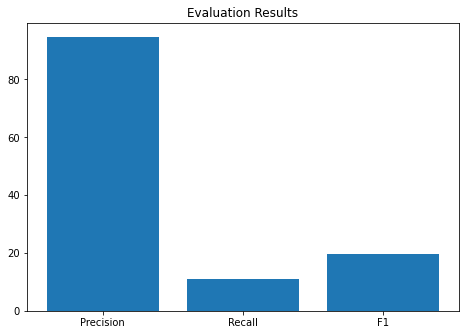

In [56]:
weightedAvgPrecision = 0; weightedAvgRecall = 0; weightedAvgF1 = 0
for category in categoriesNames:
    weightedAvgPrecision += (numAcutalData[category] * precisions[category])
    weightedAvgRecall += (numAcutalData[category] * recalls[category])
    weightedAvgF1 += (numAcutalData[category] * F1s[category])    
weightedAvgPrecision /= len(test_df)
weightedAvgRecall /= len(test_df)
weightedAvgF1 /= len(test_df)
print("Weighted Average Precision: " + str(weightedAvgPrecision) + "%")
print("Weighted Average Recall: " + str(weightedAvgRecall) + "%")
print("Weighted Average F1: " + str(weightedAvgF1) + "%")
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Evaluation Results")
words = ["Precision" , "Recall" , "F1"]
numbers = [weightedAvgPrecision , weightedAvgRecall , weightedAvgF1]
ax.bar(words , numbers)
plt.show()

In [57]:
accuracy = str((test_df["validity_without_additive_smoothing"].value_counts()[1] / len(test_df)) * 100)
print("Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = " + accuracy + "%")

Micro Average Precision = Micro Average Recall = Micro Average F1 = accuracy = 11.097256857855362%


### Question 11:
According to the results we got in the previous part, it is obvious that using additive smoothing and preprocessing will lead us to a greater accuracy, that's because in this case our model calculates the result based on every word and if a word is not in the train set it will not be able to cause the whole line probability to be zero. Since without additive smoothing we have the mentioned problem with 0, or if we're using log -inf, probability there would be low accuracy. But by using additive smoothing we got rid of that problem so we would have much higher number in evaluation. Precision values in the case of not having additive smoothing clearly shows the mentioned notes previously that having higher precision doesn't simply mean good modeling. Also we're looking for the highest possible precision and recall although they have reversed relation but in case of not having additive smoothing we clearly see that precision is high but recall is much lower so we understand that the modeling isn't great. Taking a look at case of having additive smothing, we can see that all three evalutation results are not only high but also they are close to each other that is a clear sign of a nice model. As it can be seen both additive smoothing and preprocessing have increased the acuuracy, so we can conclude that we have used a good way to preprocess our data.

### Question 12:
Naive Bayes assumes the features are independent, the probabilities are incorrect if this assumption is not correct. We are not looking at the text as a whole but instead we break the text get some info out of it and do calculations but breaking the text and not looking at it as whole will remove the relations so we'll lose some useful info. Finding the relations and adding it to our info will provide us with more evidence and so this can help us predict better.
we are analyzing texts here so the input features are dependent, and the target depends on some higher order structure hidden in the features.

In [62]:
counter = 0
for i in range(0, 5200):
    if test_df.loc[i , "validity_with_additive_smoothing"] == False:
        print("\n")
        print(test_df.loc[i , "content"])
        print("Actual Category: " + test_df.loc[i , "label"])
        print("Predicted Category: " + test_df.loc[i , "bayes_result_with_additive_smoothing"])
        counter += 1
    if(counter == 5):
        break



{'نوکیا', 'میگوید', 'قیمت', 'میخواهد', '۶۰', 'بازیگر', 'کار', 'درجه', 'Ubergizmo', 'مختص', 'میکروفون', '۳۶۰', 'قدرتمند', 'همکار', 'آماتور', 'ویدیو', 'فیلمبرداران', 'مثال', 'OZO', 'جنگل', 'ضبط', 'کمک', 'جدید', 'دستگاه', 'متعلقاتاش', 'پستولید', 'Book', 'انتخاب', 'زمان', 'استودیو', 'واقعیت', 'صدا', 'Jungle', 'سنسور', 'گذشته', 'پیشنمایش', 'سال', 'تصویر', 'اسم', 'دلاریاش', 'هزینه', 'هشت', 'شرکت', 'بلند', 'فیلمبردارهای', 'VR', 'حرف', 'میکاهد', 'میسازد', 'ساخت#ساز', 'صورت', 'تصویربرداری', 'هزار', 'مجاز', 'داخل', 'قابلیت', 'سهبعدی', 'کتاب', 'طراح', 'فیلمسازی', 'دیزنی', 'بیسیم', 'توانایی', 'دوربین', 'قرار', 'مراحل', 'هدستهای', 'نمیخورد', 'استفاده', 'اصلا', 'فیلم', 'گفت#گو', 'ساخت', 'فرستاد#فرست', 'محتوا', 'منبع', 'کوتاهتری', 'رونما', 'درد', 'اخیرا', 'تجربه', 'میتواند'}
Actual Category: هنر و سینما
Predicted Category: بازی ویدیویی


{'میگوید', 'قیمت', 'ادامه', '۵۴۹', 'گران', 'ده', 'گیگاهرتزفرکانس', 'Gigabyte', 'ویرایش', 'گیگاهرتزانرژی', '۳۹۹', 'کار', '۳۱', '۱۸۰', 'فراموش', '۱۹۵۰', 'شرط', 'میخو